# Exploring Materials Synthesis with MP Data and Reaction Networks

**Author:** Matthew McDermott  
**Version:** 08.03.21

![](assets/banner.png)

### Goal
*Learn how to build & interpret phase diagrams using MP data and apply these to predict reaction pathways in inorganic materials synthesis.*

### Outline

1. Identifying a target system
2. Building phase diagrams
	1. Exercise: identify the chemical potential at which X becomes unstable
3. Predicting interface reactions
4. Enumerating all possible reactions to a specific target phase
5. Constructing a reaction network from enumerated reactions
6. Finding and balancing reaction pathways 

## 1. Identifying a target system

**Scenario:** 

While researching ferroelectric materials, you stumble upon a compound that has shown much promise as a multiferroic material: **yttrium manganese oxide, YMnO$_3$**. When you consult the literature, it looks like there are many different approaches for making this material: solid-state (ceramic) synthesis, chimie douce methods, microwave synthesis, pulsed laser deposition, hydrothermal synthesis, etc. 

In almost all of the papers you find, the authors describe significant difficulty in synthesizing phase-pure YMnO$_3$:
- _"... observation that crystallization at low temperature or high oxygen partial pressures gives a mixture of  Y2Mn2O7 together with YMnO3" Brinks et al. Journal of Solid State Chemistry 129, 334-340 (1997)._
- _"The solid state synthesis of YMnO3 requires very long procedure with repeated heating and grinding" Z. Brankovic et al. Ceramics International 41 (2015)_
- _"There are still challenges to be addressed with respect to hydrothermal synthesis of h-YMnO3, most notably the difficulty in synthesising phase pure h-YMnO3. This is a result of the complexity of the system, with a total of eight crystalline phases having been detected throughout the course of the reaction." Marshall et al., Chem Eur. J 2020, 26, 9330-9337 (2020)._


Being familiar with the Materials Project, you decide to check the database to see if it can answer the question of: **why is phase-pure YMnO$_3$ so difficult to synthesize? Is there a better approach?**

We previously learned how to use the *MPRester* to access computed data on the Materials Project. Let's start by importing MPRester:

In [64]:
from mp_api.matproj import MPRester

Let's take a look the kinds of structures that are on the Materials Project with the composition YMnO$_3$:

In [65]:
import pandas
import crystal_toolkit

In [66]:
with MPRester() as mpr:
    entries = mpr.get_entries(chemsys_formula="YMnO3")

Let's take a look at one of the entry objects:

In the ComputedStructureEntry printout, we can see the uncorrected energy, correction, final energy, and the various parameters/data associated with the calculation.

Since this is hard to interpret, it will be easier for us to reformat the entries into a DataFrame with the relevant information:

In [67]:
def get_dataframe_from_entries(entries):
    formulas = [e.composition.reduced_formula for e in entries]
    energies = [e.energy_per_atom for e in entries]
    spacegroups = [e.structure.get_space_group_info()[0] for e in entries]
    structures = [e.structure for e in entries]
    
    df = pandas.DataFrame(
        {"formula": formulas, "energy": energies, "spacegroup": spacegroups, "entry":entries}
    ).sort_values("energy")
    
    return df

In [68]:
df = get_dataframe_from_entries(entries)
df

,formula,energy,spacegroup,entry
4,YMnO3,-9.130481,P6_3cm,mp-19385 ComputedStructureEntry - Y6 Mn6 O18 ...
0,YMnO3,-9.109891,P6_3/mmc,mp-19227 ComputedStructureEntry - Y2 Mn2 O6 ...
3,YMnO3,-9.107394,Pnma,mp-20699 ComputedStructureEntry - Y4 Mn4 O12 ...
1,YMnO3,-8.805429,Pm-3m,mp-1434307 ComputedStructureEntry - Y1 Mn1 O3 ...
2,YMnO3,-8.731478,Pnma,mp-20699 ComputedStructureEntry - Y4 Mn4 O12 ...


In [69]:
df.iloc[0]["entry"].structure

If you see this text, the Crystal Toolkit Jupyter Lab 

extension is not installed. You can install it by running 

"pip install crystaltoolkit-extension" 

from the same environment you run "jupyter lab". 

This only works in Jupyter Lab 3.x or above.


Structure Summary
Lattice
    abc : 6.2330216584852325 6.2330216584852325 11.58909
 angles : 90.0 90.0 119.99999637504301
 volume : 389.9215651386502
      A : 3.116511 -5.397955 0.0
      B : 3.116511 5.397955 0.0
      C : 0.0 0.0 11.58909
PeriodicSite: Y (3.1165, -1.7993, 2.7008) [0.6667, 0.3333, 0.2330]
PeriodicSite: Y (3.1165, 1.7993, 8.4953) [0.3333, 0.6667, 0.7330]
PeriodicSite: Y (3.1165, -1.7993, 8.4953) [0.6667, 0.3333, 0.7330]
PeriodicSite: Y (3.1165, 1.7993, 2.7008) [0.3333, 0.6667, 0.2330]
PeriodicSite: Y (0.0000, 0.0000, 8.9929) [0.0000, 0.0000, 0.7760]
PeriodicSite: Y (0.0000, 0.0000, 3.1983) [0.0000, 0.0000, 0.2760]
PeriodicSite: Mn (2.0768, -3.5972, 5.8105) [0.6664, 0.0000, 0.5014]
PeriodicSite: Mn (4.1537, 0.0000, 0.0

 We see that there are several polymorphs of similar energy. The lowest energy polymorph is the hexagonal YMnO3 phase which is well known as the stable phase in the literature.

## 2. Building phase diagrams

Now that we've confirmed the existence of the target phase within the MP database, we'd like to better understand phase composition within the Y-Mn-O system. This means answering questions suchs as:

1. Just how stable is YMnO$_3$? 
2. How much energy is released upon formation of YMnO$_3$ from binary oxides vs. the elements?
3. What other phases might compete against the formation of YMnO$_3$? 
4. What kinds of oxygen chemical potentials stabilize YMnO$_3$? 

These are all questions that can be answered by constructing simple phase diagrams within pymatgen. Let's start by downloading entries for the full Y-Mn-O system using MPRester.

### 2.1 Acquiring entries in the chemical system

In [70]:
with MPRester() as mpr:
    entries = mpr.get_entries_in_chemsys("Y-Mn-O")

In [71]:
len(entries)

160

### 2.2 Compositional phase diagrams

We can create a ternary compositional phase diagram by simply passing the list of entries to create a PhaseDiagram object:

In [72]:
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

pd = PhaseDiagram(entries)

We can plot the PhaseDiagram object by initializing a PDPlotter object and calling get_plot():

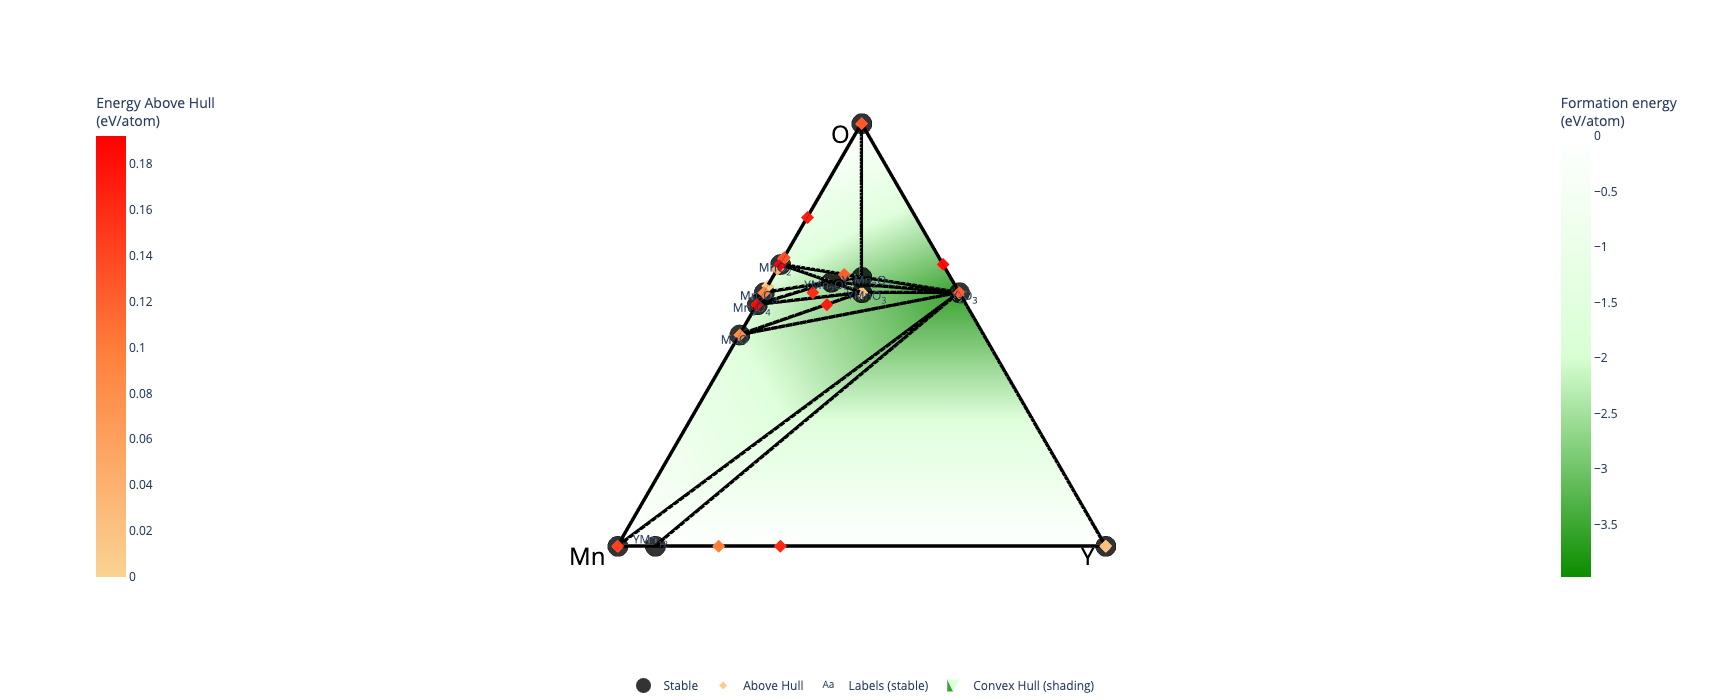

In [73]:
pd.get_plot()

From the phase diagram, we see that there are three ternary oxides within the system: YMnO$_3$, YMn$_2$O$_5$, and Y$_2$Mn$_2$O$_7$. 

Let's look at the phase diagram formation energy data in a pandas `DataFrame`:

In [74]:
def get_dataframe_from_pd(pd):
    ents = pd.stable_entries
    
    formulas = [e.composition.reduced_formula for e in ents]
    form_energies = [pd.get_form_energy_per_atom(e) for e in ents]
    decomp_enthalpies = [pd.get_phase_separation_energy(e) for e in ents]
    
    df = pandas.DataFrame(
        {"formula": formulas, "form_energy": form_energies, "decomp_enthalpy": decomp_enthalpies}
    ).sort_values("form_energy").reset_index(drop=True)
    
    return df

In [75]:
get_dataframe_from_pd(pd)

,formula,form_energy,decomp_enthalpy
0,Y2O3,-3.970920,-0.856833
1,YMnO3,-3.036007,-0.029013
2,Y2Mn2O7,-2.877818,-0.056013
3,YMn2O5,-2.639070,-0.031220
4,Mn3O4,-2.050443,-0.046443
5,Mn2O3,-2.013920,-0.024500
6,MnO,-1.979201,-0.185063
7,MnO2,-1.805830,-0.066579
8,YMn12,-0.001407,-0.001407
9,O2,0.000000,0.000000


While YMnO$_3$ has one of the lowest formation energies within the Y-Mn-O system, it's decomposition enthalpy (energy "below" hull) is not very negative compared to the other phases in the system. This suggests that it has a low relative stability compared to the neighboring phases.

This is largely due to the fact that **Y$_2$O$_3$ is a massive thermodynamic sink** -- it has both the most negative formation energy and the most negative decomposition enthalpy. We can even see this on the color-shading of the ternary phase diagram.


### 2.3 Compound phase diagrams for plotting subsets of the convex hull

The previous analysis partially explains why synthesis routes to YMnO3 from the starting binary oxides (i.e. Y$_2$O$_3$ and Mn$_2$O$_3$) require such high temperatures to proceed. We can take a slice of the hull with the `CompoundPhaseDiagram` to visualize this:

In [76]:
from pymatgen.core.composition import Composition
from pymatgen.analysis.phase_diagram import CompoundPhaseDiagram

terminal_comps = [Composition("Y2O3"), Composition("Mn2O3")]
cpd = CompoundPhaseDiagram(entries, terminal_comps)

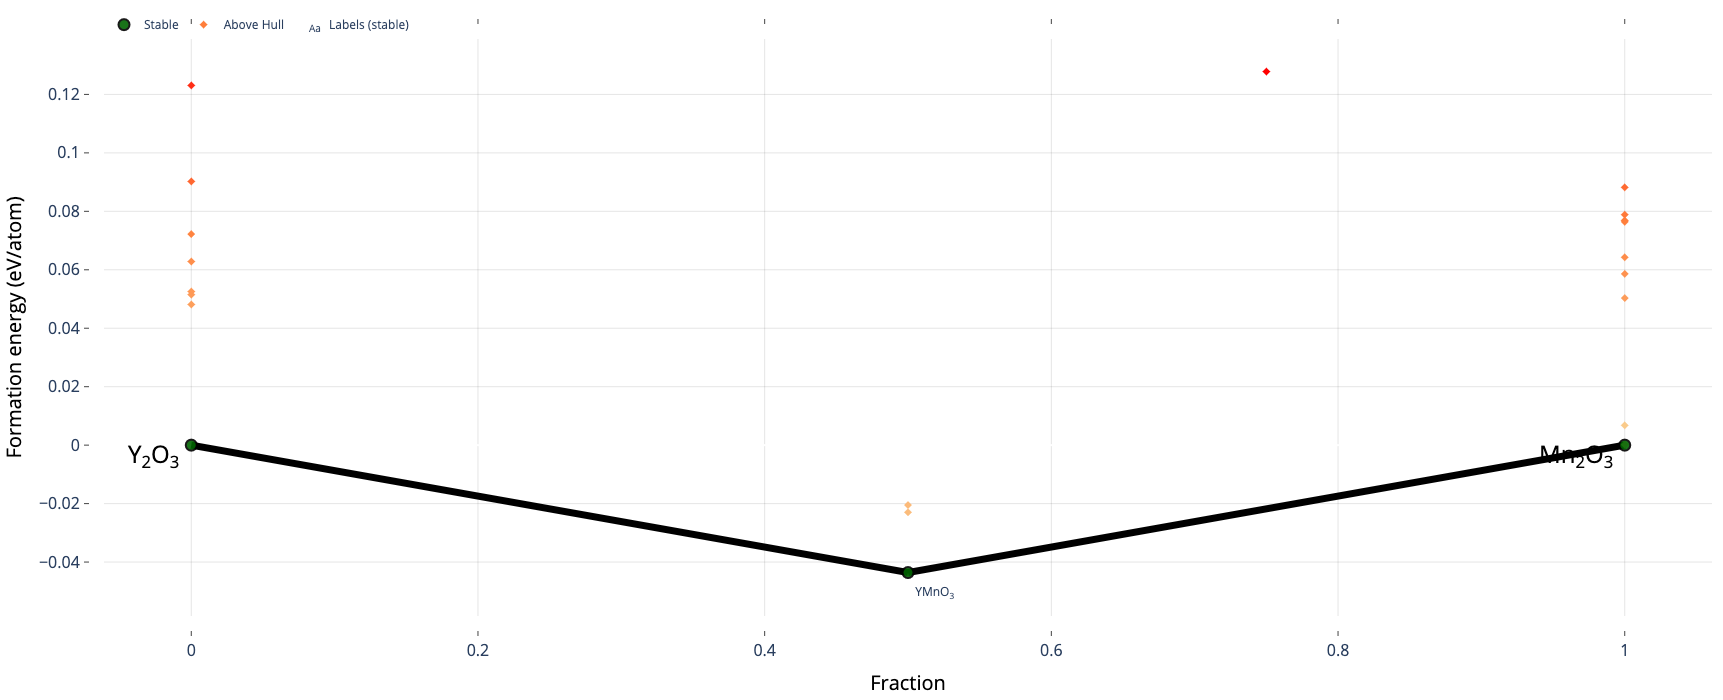

In [77]:
cpd.get_plot()

From the plot, if we hover over YMnO3, we see that the reaction energy between Y2O3-Mn2O3 is calculated to be dH = -0.044 eV/atom.

An alternative way to derive this is by providing the entries to the ComputedReaction object, which will automatically balance the reaction for us:

In [78]:
from pymatgen.analysis.reaction_calculator import ComputedReaction

reactants = [e for e in pd.stable_entries if e.composition.reduced_formula in ["Y2O3", "Mn2O3"]]
products = [e for e in pd.stable_entries if e.composition.reduced_formula in ["YMnO3"]]

rxn = ComputedReaction(reactants, products)
print(rxn)

0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3


**Note:** The reaction energy associated with the ComputedReaction object is eV per mole of reaction (i.e. per mole of YMnO3):

In [79]:
rxn_energy = rxn.calculated_reaction_energy
print(rxn_energy)

-0.21793684385414736


However, if we calculate the number of atoms in the reaction we can normalize this to a a **reaction energy per atom** basis:

In [80]:
num_atoms = sum([rxn.get_el_amount(elem) for elem in rxn.elements])
rxn_energy_per_atom = rxn_energy / num_atoms
print(round(rxn_energy_per_atom, 3))

-0.044


And now we see that the -0.044 eV/atom reaction energy matches with the result from the CompoundPhaseDiagram interface.

Note that the `CompoundPhaseDiagram` is also useful for plotting subsections of the convex hull:

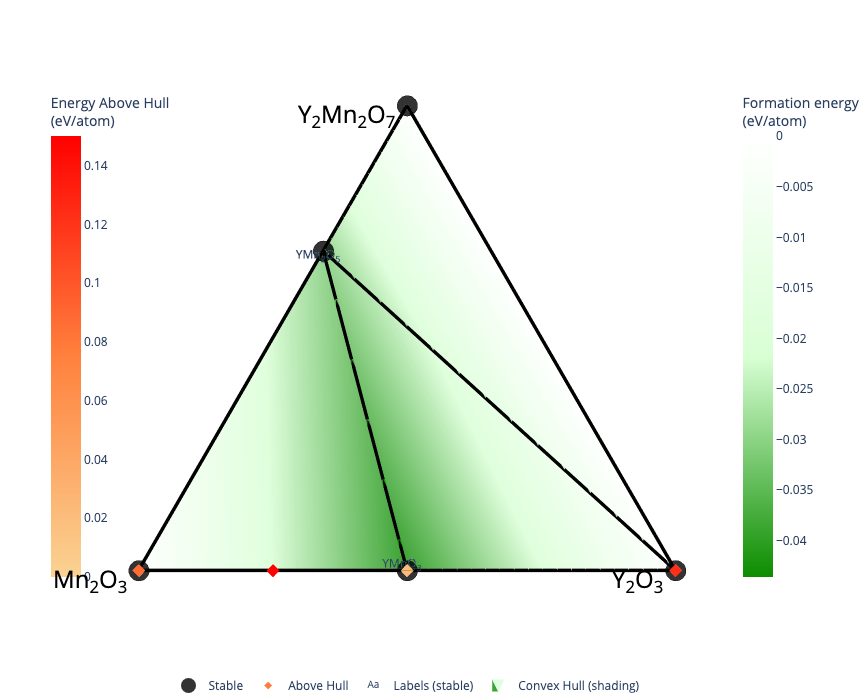

In [84]:
comps = [Composition(c) for c in ["Y2O3", "Mn2O3", "Y2Mn2O7"]]
CompoundPhaseDiagram(entries, comps).get_plot()

### 2.4 Incorporating temperature-dependence with a previously derived ML model ($G_{SISSO}$) and expt data

The Materials Project contains DFT-calculated energies for commpounds at T=0 K. Since most experimental syntheses take place well above 0 K, it is useful to have some idea of how the phase diagram (and hence reaction energies, relative stabilities, etc.) change with increasing temperature.

A recent work by Bartel et al. derived an equation to estimate the Gibbs free energy of formation of solids, $\Delta G_f(T)$, as a function of temperature using the MP formation enthalpy (T=298 K) as a reference. This has been implemented within pymatgen as the `GibbsComputedStructureEntry` class. Note that this implementation also includes the change in elemental chemical potentials as a function of temperature, as well as as the thermochemistry data for some known gases such as CO$_2$.

**Reference**: 
##### _Bartel, C. J., Millican, S. L., Deml, A. M., Rumptz, J. R., Tumas, W., Weimer, A. W., … Holder, A. M. (2018). Physical descriptor for the Gibbs energy of inorganic crystalline solids and temperature-dependent materials chemistry. Nature Communications, 9(1), 4168. https://doi.org/10.1038/s41467-018-06682-4_

We can create the phase diagram at T = 2000 K and compare this to our previous MP (T=298 K) phase diagraam:

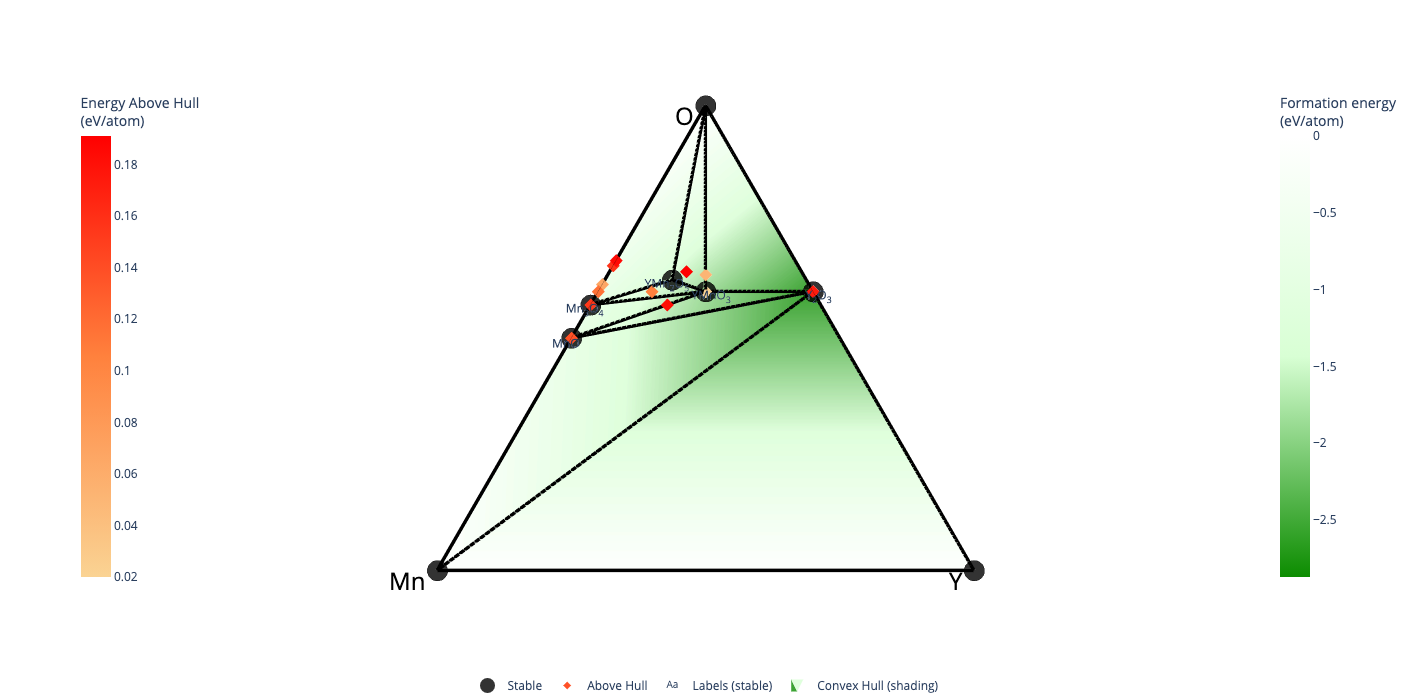

In [97]:
from pymatgen.entries.computed_entries import GibbsComputedStructureEntry

gibbs_entries = GibbsComputedStructureEntry.from_entries(entries, temp=2000)

pd_gibbs = PhaseDiagram(gibbs_entries)
pd_gibbs.get_plot()

We see that Mn2O3, MnO2, and Y2Mn2O7 are all predicted to become significantly destabilized at higher temperatures. While some of this behavior could arise from differences in solid-state entropies, this is most likely a result of the significant decrease in oxygen chemical potential at high temperatures, which creates more reducing conditions that favor phases containing less oxygen. 

### 2.5 Grand potential phase diagrams for open elements
In solid-state synthesis, materials are often synthesized in some type of gaseous environment. This may be an inert gas, flowing/controlled oxygen, etc. A common question in materials synthesis is: **what kind of atmosphere do I need to promote the synthesis of my target material?**

For oxides such as YMnO$_3$ this means determining how oxidizing/reducing the environment should be: i.e. determining the partial pressure (and hence chemical potential) of oxygen.

In thermodynamics, a system open to an element can be modeled with the grand potential, $\phi$. For open oxygen, this corresponds to:

$$\phi = G - \mu_On_O$$

We can switch to the grand potential by using the GrandPotentialPhaseDiagram within pymatgen. From now on, we will use `GibbsComputedStructureEntry` objects, as they are referenced to a standard state where elemental chemical potentials are 0 eV. This helps us better understand chemical potentials as a function of formation energies (rather than DFT energies).

In [87]:
from pymatgen.core.composition import Element
from pymatgen.analysis.phase_diagram import GrandPotentialPhaseDiagram

In [228]:
temp = 1000 # K
gibbs_entries = GibbsComputedStructureEntry.from_entries(entries, temp=temp)

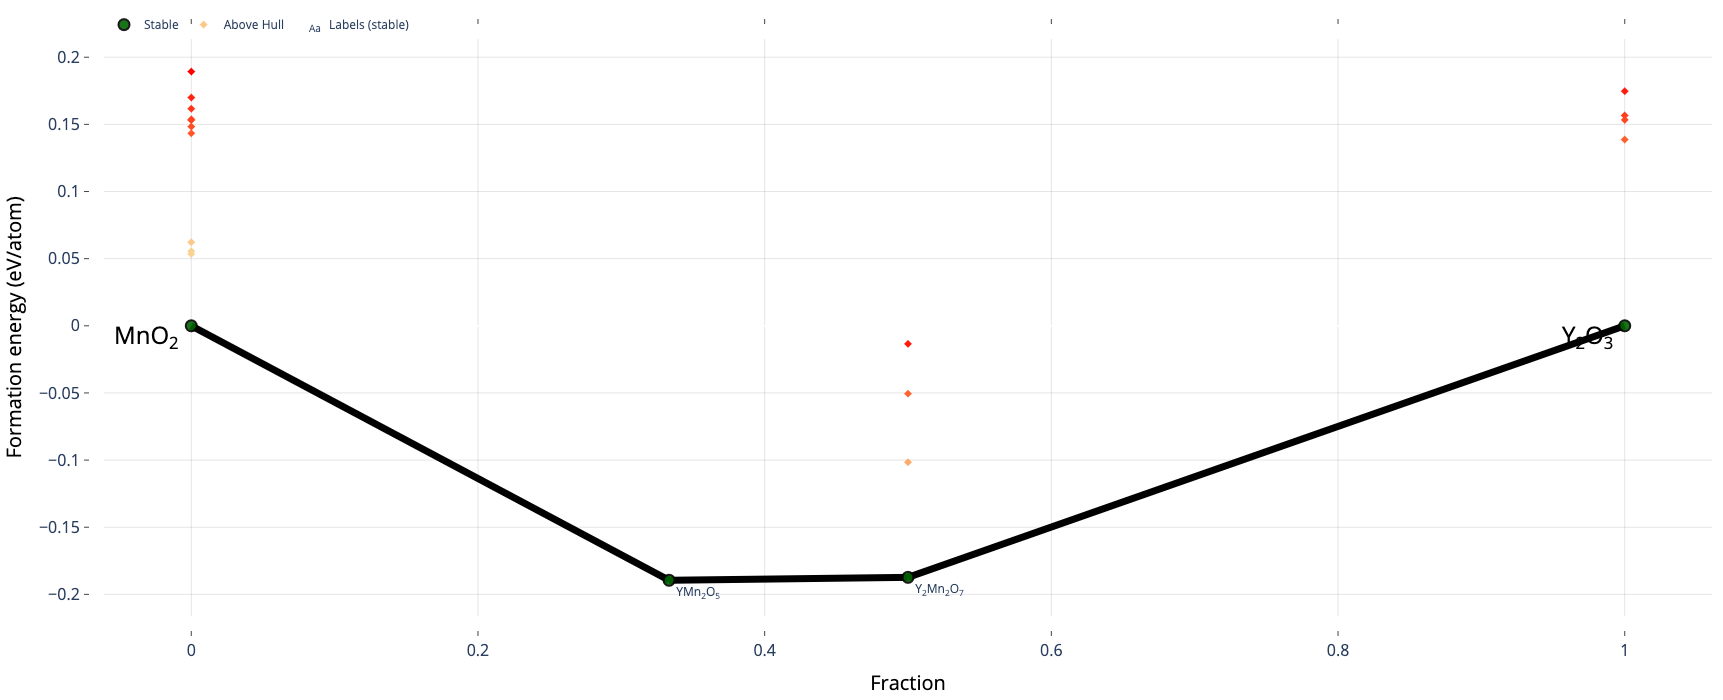

In [229]:
open_elem = Element("O")
chempot = 0
GrandPotentialPhaseDiagram(gibbs_entries, {open_elem: chempot})

From the grand potential phase diagram above, we see that only YMn2O5 and Y2Mn2O7 are stable at a relative oxygen chemical potential of 0 eV at T = 1000 K. This corresponds to flowing (open) oxygen gas at the standard state of pressure of 0.1 MPa (close to 1 atm).

Note that the is for a binary system, since we have removed a degree of freedom in fixing the oxygen chemical potential to a specific value.

#### 2.5.2 Exercise

Determine the partial pressure of oxygen (T = 1000 K) where YMnO3 becomes stable.

**Hint:** *Determine the chemical potential of oxygen and use the following formula to solve for the pressure:*

$$ \mu - \mu^0 = k_b T \ln{\frac{p}{p_0}} $$

In [216]:
from math import exp
k = 8.617e-5  # eV/K
T = 1000  # K

mu_oxygen = -0.343 * 2  # found manually from phase diagram construction

pressure = 0.1*exp(mu_oxygen/(k*T))  # MPa
print(f"{round(pressure, 7)} MPa")

3.49e-05 MPa


This is quite a low O2 partial pressure. However, note that this value is extremely sensitive to small differences in calculated formation energies for the compounds. 

Temperature is often an even more powerful driver for oxidizing/reducing conditions than pressure. In fact, at higher temperatures (T = 1400 K), YMnO3 is predicted to be stable even at the standard state (0.1 MPa) pressure.

#### 2.5.3 Finding "critical" chemical potentials

As was hinted at above, all phases on the compositional phase diagram are stable within a certain region of chemical potentials. These do not need to be found manually as above, instead there are methods to solve for them algorithmically. For YMnO3, we get:

In [237]:
pd_gibbs = PhaseDiagram(gibbs_entries)
pd_gibbs.get_chempot_range_stability_phase(Composition("YMnO3"), open_elt=Element("O"))

{Element Y: (-5.684675115489508, -8.059642293382048),
 Element Mn: (-1.1179289454355414, -3.492896123328082),
 Element O: (-1.9261348812004853, -0.3428234292721252)}

Note that the upper bound value of chemical potential for oxygen matches what we found in the previous exercise (-0.343 eV).

### 2.6 Plotting predominance diagrams

The chemical potential ranges over which a phase is stable can be plotted in a new diagram, historically called a predominance diagram. Because one chemical potential is always dependent, we only need 2 dimensions to represent the chemical potential stability regions. These form polygons, which are not necessarily rectangular!

**Note:** the -0.343 eV value where YMnO3 becomes stable is actually the tip of the narrow YMnO3 polygon!

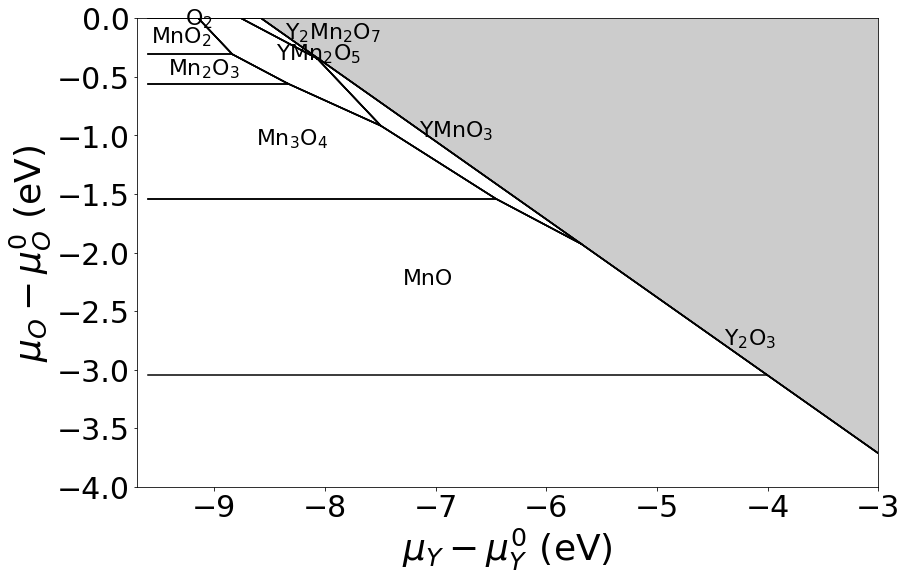

In [257]:
plotter = PDPlotter(pd_gibbs)
plot = plotter.get_chempot_range_map_plot(elements=[Element("Y"), Element("O")])
plot.xlim(-9.7, -3)
plot.ylim(-4,0)
plot.show()

### 2.7 BONUS: Plotting chemical potential diagrams (adding one more dimension!)

It is often even more convenient to visualize all three dimensions within chemical potential space. For this, we can plot a **chemical potential diagram**. For now, this code only exists in the (separate) reaction-network package, but will be added soon to pymatgen.

In [259]:
from rxn_network.thermo.chempot_diagram import ChempotDiagram

In [278]:
limits={Element("Y"): (-10, 0),
        Element("Mn"): (-10, 0),
        Element("O"): (-7, 0)
       }
cd = ChempotDiagram(pd_gibbs, limits = limits)
cd.get_plot()

From the chemical potential diagram, we can easily see the relative stabilities of each phase and get a visual picture of where the critical chemical potentials are for each phase.

## 3. Predicting interface reactions between solids

In solid-state synthesis, precursor compounds are milled into powders of small solid crystallites. These powders are intimately mixed, typically pressed into a pellt, and then heated in a furnace. Typically, solid-state synthesis involves high temperatures and 

![](assets/interface_rxn.png)

## 4. Enumerating all reactions within a chemical system

## 5. Constructing a reaction network from enumerated reactions

## 6. Finding and balancing reaction pathways